This notebook is taken from [Zack Mueller's](https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/05_Style_Transfer.ipynb) codebase.

In [0]:
#default_exp style_transfer

# fastai2 libraries

In [1]:
#export
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

# Our Pre-Trained Network:
* vgg-19:
  * Small CNN pre-trained on ImageNet
  * Only 19 layers deep

In [2]:
#export
from torchvision.models import vgg19, vgg16

In [3]:
feat_net = vgg19(pretrained=True).features.cuda().eval()

We'll get rid of the head and use the internal activations (and our generator model's loss). As a result, we want to set every layer to un-trainable

In [4]:
for p in feat_net.parameters(): p.requries_grad=False

We will be using feature detections that our model picks up, which is like our heatmaps generated for our Classification models

In [5]:
layers = [feat_net[i] for i in [1, 6, 11, 20, 29, 22]]; layers

[ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True)]

The outputs are `ReLU` layers. Below is a configuration for the 16 and 19 models

In [6]:
#export
_vgg_config = {
    'vgg16' : [1, 11, 18, 25, 20],
    'vgg19' : [1, 6, 11, 20, 29, 22]
}

Let's write a quick `get_layers` function to grab our network and the layers

In [7]:
#export 
def _get_layers(arch:str, pretrained=True):
    "Get the layers and arch for a VGG Model (16 and 19 are supported only)"
    feat_net = vgg19(pretrained=pretrained).cuda() if arch.find('9') > 1 else vgg16(pretrained=pretrained).cuda()
    config = _vgg_config.get(arch)
    features = feat_net.features.cuda().eval()
    for p in features.parameters(): p.requires_grad=False
    return feat_net, [features[i] for i in config]

Now let's make it all in one go utilizing our private functions to pass in an architecture name and a `pretrained` parameter

In [8]:
#export
def get_feats(arch:str, pretrained=True):
    "Get the features of an architecture"
    feat_net, layers = _get_layers(arch, pretrained)
    hooks = hook_outputs(layers, detach=False)
    def _inner(x):
        feat_net(x)
        return hooks.stored
    return _inner

In [9]:
feats = get_feats('vgg19')

# The Loss Function


Our loss fuction needs:

* Our original image
* Some artwork / style
* Activation features from our encoder

Let's grab the image

In [10]:
fn = '/home/ubuntu/datasets/tv_show_logos/rick_and_morty2.jpg'

We can now make a `PipeLine` to convert our image into a `Tensor` to use in our loss function. We'll want to use the `Datasets` for this

In [11]:
dset = Datasets(fn, tfms=[PILImage.create])

In [12]:
dl = dset.dataloaders(after_item=[ToTensor()], after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)], bs=1)

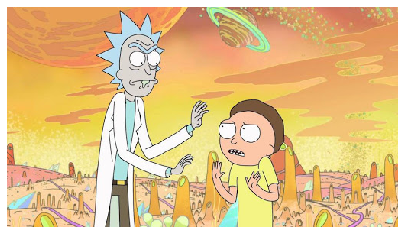

In [13]:
dl.show_batch(figsize=(7,7))

In [14]:
style_im = dl.one_batch()[0]

In [15]:
style_im.shape

torch.Size([1, 3, 288, 512])

In [16]:
#export
def get_style_im(url):
  download_url(url, 'style.jpg')
  fn = 'style.jpg'
  dset = Datasets(fn, tfms=[PILImage.create])
  dl = dset.dataloaders(after_item=[ToTensor()], after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)], bs=1)
  return dl.one_batch()[0]

We can then grab the features using our `feats` function we made earlier

In [17]:
im_feats = feats(style_im)

Let's look at their sizes

In [18]:
for feat in im_feats:
    print(feat.shape)

torch.Size([1, 64, 288, 512])
torch.Size([1, 128, 144, 256])
torch.Size([1, 256, 72, 128])
torch.Size([1, 512, 36, 64])
torch.Size([1, 512, 18, 32])
torch.Size([1, 512, 36, 64])


Now we can bring those images down to the channel size

In [19]:
#export
def gram(x:Tensor):
    "Transpose a tensor based on c,w,h"
    n, c, h, w = x.shape
    x = x.view(n, c, -1)
    return (x @ x.transpose(1, 2))/(c*w*h)

In [20]:
im_grams = [gram(f) for f in im_feats]

In [21]:
for feat in im_grams:
    print(feat.shape)

torch.Size([1, 64, 64])
torch.Size([1, 128, 128])
torch.Size([1, 256, 256])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])


In [22]:
#export
def get_stl_fs(fs): return fs[:-1]

We're almost there! Let's look at why that was important

In [23]:
#export
def style_loss(inp:Tensor, out_feat:Tensor):
    "Calculate style loss, assumes we have `im_grams`"
    # Get batch size
    bs = inp[0].shape[0]
    loss = []
    # For every item in our inputs
    for y, f in zip(*map(get_stl_fs, [im_grams, inp])):
        # Calculate MSE
        loss.append(F.mse_loss(y.repeat(bs, 1, 1), gram(f)))
    # Multiply their sum by 30000
    return 3e5 * sum(loss)

Great, so what now? Let's make a loss function for `fastai2`!
* Remember, we do not care to use any initial metrics

In [24]:
#export
class FeatureLoss(Module):
    "Combines two losses and features into a useable loss function"
    def __init__(self, feats, style_loss, act_loss):
        store_attr(self, 'feats, style_loss, act_loss')
        self.reset_metrics()

    def forward(self, pred, targ):
        # First get the features of our prediction and target
        pred_feat, targ_feat = self.feats(pred), self.feats(targ)
        # Calculate style and activation loss
        style_loss = self.style_loss(pred_feat, targ_feat)
        act_loss = self.act_loss(pred_feat, targ_feat)
        # Store the loss
        self._add_loss(style_loss, act_loss)
        # Return the sum
        return style_loss + act_loss

    def reset_metrics(self):
        # Generates a blank metric
        self.metrics = dict(style = [], content = [])

    def _add_loss(self, style_loss, act_loss):
        # Add to our metrics
        self.metrics['style'].append(style_loss)
        self.metrics['content'].append(act_loss)

In [25]:
#export
def act_loss(inp:Tensor, targ:Tensor):
    "Calculate the MSE loss of the activation layers"
    return F.mse_loss(inp[-1], targ[-1])

Let's declare our loss function by passing in our features and our two 'mini' loss functions

In [26]:
loss_func = FeatureLoss(feats, style_loss, act_loss)

# The Model Architecture
Let's now build our model

In [27]:
#export
class ReflectionLayer(Module):
    "A series of Reflection Padding followed by a ConvLayer"
    def __init__(self, in_channels, out_channels, ks=3, stride=2):
        reflection_padding = ks // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, ks, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

In [28]:
ReflectionLayer(3, 3)

ReflectionLayer(
  (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
  (conv2d): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2))
)

In [29]:
#export
class ResidualBlock(Module):
    "Two reflection layers and an added activation function with residual"
    def __init__(self, channels):
        self.conv1 = ReflectionLayer(channels, channels, ks=3, stride=1)
        self.in1 = nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ReflectionLayer(channels, channels, ks=3, stride=1)
        self.in2 = nn.InstanceNorm2d(channels, affine=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out

In [30]:
ResidualBlock(3)

ResidualBlock(
  (conv1): ReflectionLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  )
  (in1): InstanceNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2): ReflectionLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  )
  (in2): InstanceNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (relu): ReLU()
)

In [31]:
#export
class UpsampleConvLayer(Module):
    "Upsample with a ReflectionLayer"
    def __init__(self, in_channels, out_channels, ks=3, stride=1, upsample=None):
        self.upsample = upsample
        reflection_padding = ks // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, ks, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

Let's put everything together into a model

In [32]:
#export
class TransformerNet(Module):
    "A simple network for style transfer"
    def __init__(self):
        # Initial convolution layers
        self.conv1 = ReflectionLayer(3, 32, ks=9, stride=1)
        self.in1 = nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ReflectionLayer(32, 64, ks=3, stride=2)
        self.in2 = nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ReflectionLayer(64, 128, ks=3, stride=2)
        self.in3 = nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(128, 64, ks=3, stride=1, upsample=2)
        self.in4 = nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, ks=3, stride=1, upsample=2)
        self.in5 = nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ReflectionLayer(32, 3, ks=9, stride=1)
        # Non-linearities
        self.relu = nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y

In [33]:
net = TransformerNet()

# DataLoaders and Learner

We will be using a tiny custom dataset I created using logos of popular tv shows

In [40]:
path = Path("/home/ubuntu/datasets/tv_show_logos/")

Our `DataBlock` needs to be Image -> Image

In [41]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(0.1, seed=42),
                   item_tfms=[Resize(224)],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

If you do not pass in a `get_y`, `fastai2` will assume your input = output

In [44]:
dls = dblock.dataloaders(path, bs=9)

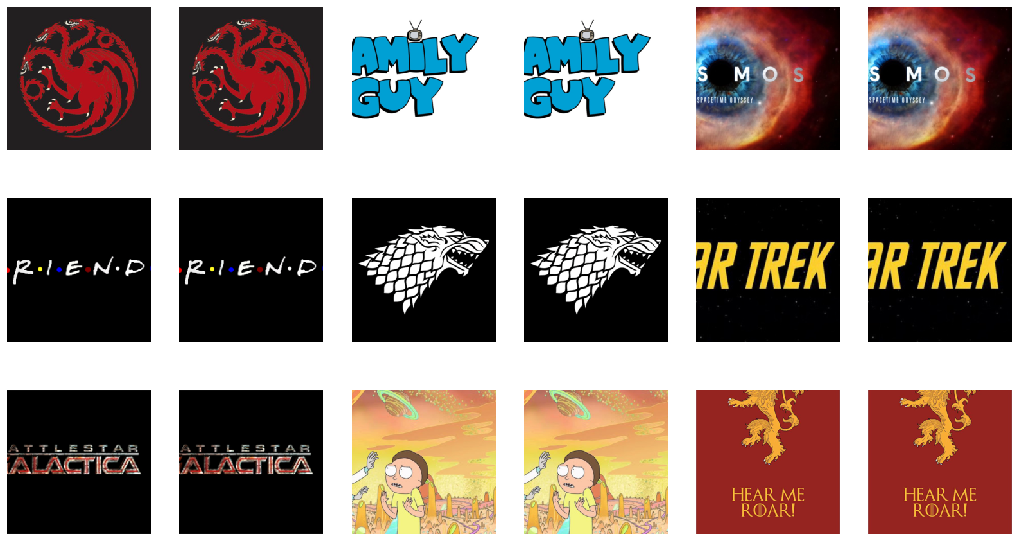

In [45]:
dls.show_batch()

We now can make our `Learner`!

In [64]:
learn = Learner(dls, TransformerNet(), loss_func=loss_func)

In [65]:
learn.summary()

TransformerNet (Input shape: ['9 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
ReflectionPad2d      9 x 3 x 232 x 232    0          False     
________________________________________________________________
Conv2d               9 x 32 x 224 x 224   7,808      True      
________________________________________________________________
InstanceNorm2d       9 x 32 x 224 x 224   64         True      
________________________________________________________________
ReflectionPad2d      9 x 32 x 226 x 226   0          False     
________________________________________________________________
Conv2d               9 x 64 x 112 x 112   18,496     True      
________________________________________________________________
InstanceNorm2d       9 x 64 x 112 x 112   128        True      
________________________________________________________________
ReflectionPad2d      9 x 64 x 114 x 114   0          False     
______________________________________________

Let's find a learning rate and fit for one epoch

(0.0009120108559727668, 0.004365158267319202)

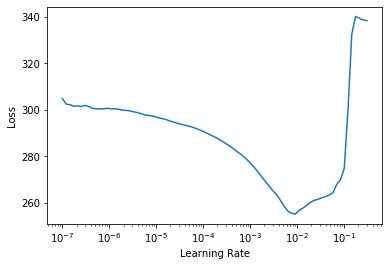

In [66]:
learn.lr_find()

In [67]:
learn.fit_one_cycle(30, 1e-3)

epoch,train_loss,valid_loss,time
0,300.977203,289.369202,00:01
1,292.924500,284.450928,00:00
2,291.210419,280.373779,00:01
3,289.064972,272.931305,00:01
4,285.380035,272.622314,00:01
5,282.266174,263.347321,00:01
6,279.503143,252.585083,00:01
7,275.597656,251.740280,00:01
8,272.752625,247.618698,00:01
9,270.604248,246.656204,00:01


And take a look at some of our results!

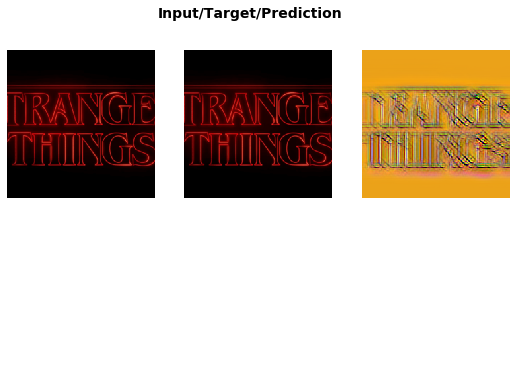

In [68]:
learn.show_results()

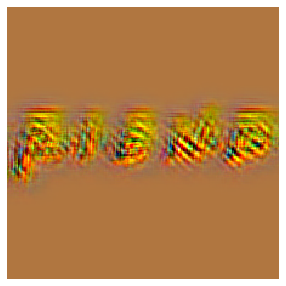

In [57]:
pred = learn.predict('/home/ubuntu/datasets/tv_show_logos/friends.png')
pred[0].show()

^ That does not look good. Let's train it more.

(0.0002511886414140463, 0.0014454397605732083)

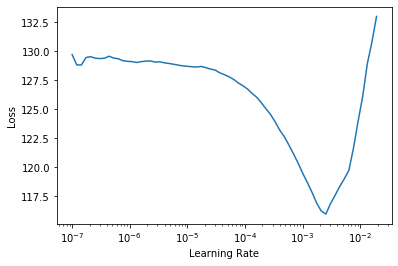

In [69]:
learn.lr_find()

In [70]:
learn.fit_one_cycle(30, 1e-3)

epoch,train_loss,valid_loss,time
0,131.067169,160.659714,00:01
1,130.398224,157.158493,00:01
2,129.423782,150.855408,00:01
3,128.354004,145.027939,00:01
4,126.920013,140.091553,00:01
5,124.881836,150.169159,00:01
6,123.035378,163.410782,00:01
7,121.015465,119.752457,00:01
8,121.018959,125.896919,00:01
9,119.080109,194.587799,00:01


In [71]:
learn.save('tv-logos-stage2')

Now let's try `learn.predict`

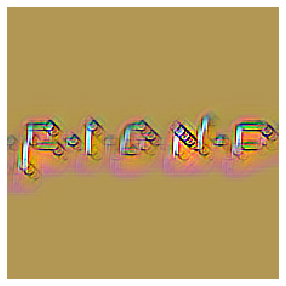

In [72]:
pred = learn.predict('/home/ubuntu/datasets/tv_show_logos/friends.png')
pred[0].show()

^ Looks better than stage 1 but it needs more training.

(0.00020892962347716094, 0.0010000000474974513)

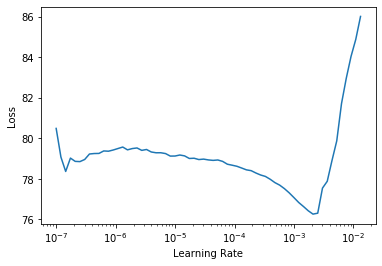

In [73]:
learn.lr_find()

In [74]:
learn.fit_one_cycle(30, 1e-3)

epoch,train_loss,valid_loss,time
0,79.920364,107.164406,00:01
1,79.152153,106.853989,00:01
2,78.972977,106.995720,00:01
3,79.064354,107.643677,00:01
4,79.110901,108.579567,00:01
5,78.664276,105.099014,00:01
6,78.321709,97.642227,00:01
7,78.001137,92.200722,00:01
8,77.638260,95.921837,00:01
9,77.140884,95.984352,00:01


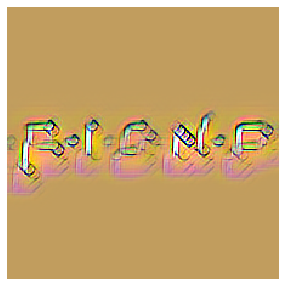

In [75]:
pred = learn.predict('/home/ubuntu/datasets/tv_show_logos/friends.png')
pred[0].show()

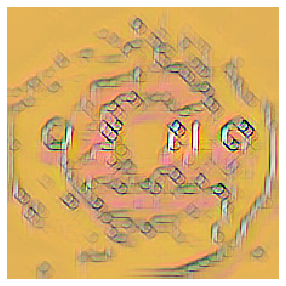

In [76]:
pred = learn.predict('/home/ubuntu/datasets/tv_show_logos/cosmos.jpg')
pred[0].show()

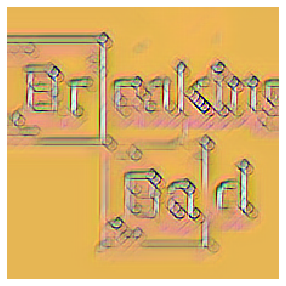

In [78]:
pred = learn.predict('/home/ubuntu/datasets/tv_show_logos/breaking_bad.png')
pred[0].show()

In [79]:
learn.save('tv-logos-stage3')

In [80]:
learn.fit_one_cycle(30, 1e-3)

epoch,train_loss,valid_loss,time
0,59.946503,85.400246,00:01
1,61.008160,84.966888,00:01
2,60.119385,84.078934,00:01
3,60.188206,83.167496,00:01
4,60.032352,84.909256,00:01
5,59.482407,85.995529,00:01
6,59.208469,82.557518,00:01
7,59.312057,99.480347,00:01
8,60.201027,87.419487,00:01
9,60.733902,93.928726,00:01


^ That didn't help much, let's try learn.fir instead of learn.fit_one_cycle.

In [83]:
learn.load('tv-logos-stage3')
learn.fit(30, 1e-3)

epoch,train_loss,valid_loss,time
0,60.870510,84.069191,00:01
1,60.396744,84.506493,00:01
2,60.373665,84.028069,00:01
3,60.105236,82.713348,00:01
4,59.917351,81.168259,00:01
5,59.422260,83.812820,00:01
6,58.782505,87.849457,00:01
7,58.452793,88.588455,00:01
8,58.262516,83.582123,00:01
9,57.967041,78.043182,00:01


In [85]:
learn.fit(30, 1e-3)

epoch,train_loss,valid_loss,time
0,48.937305,72.690720,00:01
1,48.545837,71.797897,00:01
2,48.490131,70.638405,00:01
3,48.498692,71.304558,00:01
4,48.429802,70.187317,00:01
5,48.160667,70.362633,00:01
6,47.936821,71.592644,00:01
7,47.706009,72.815102,00:01
8,47.632339,73.070969,00:01
9,47.517117,70.028450,00:01


In [86]:
#learn.save('tv-logos-stage4')
learn.fit(30, 1e-3)

epoch,train_loss,valid_loss,time
0,41.501163,63.886044,00:01
1,42.243774,64.303696,00:01
2,42.414074,66.499054,00:01
3,42.483448,69.267311,00:01
4,42.053768,68.682236,00:01
5,41.976254,66.725578,00:01
6,41.979233,63.206596,00:01
7,41.862892,62.747292,00:01
8,41.743847,64.309143,00:01
9,41.639885,66.510895,00:01


In [87]:
#learn.save('tv-logos-stage4')

(3.0199516913853586e-06, 7.585775847473997e-07)

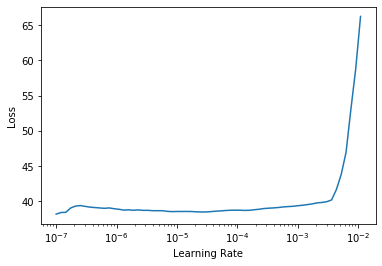

In [88]:
learn.lr_find()

In [89]:
learn.fit_one_cycle(30, 1e-3/3)

epoch,train_loss,valid_loss,time
0,39.050358,61.804157,00:01
1,38.526608,61.733719,00:01
2,38.594292,61.396477,00:01
3,38.627728,60.858856,00:01
4,38.405968,60.551128,00:01
5,38.489296,60.041466,00:01
6,38.516342,60.007050,00:01
7,38.539673,61.353123,00:01
8,38.489296,61.003616,00:01
9,38.402447,60.213509,00:01


In [90]:
learn.save('tv-logos-stage4')

Well while that looks cool, we lost a lot of the features! How can we fix this? Let's try something similar to what we did for our `style_im`

In [59]:
# learn.load('tv-logos-stage1')

In [91]:
dset = Datasets('/home/ubuntu/datasets/tv_show_logos/friends.png', tfms=[PILImage.create])
dl = dset.dataloaders(after_item=[ToTensor()], after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)], bs=1)

In [92]:
t_im = dl.one_batch()[0]

In [93]:
with torch.no_grad():
  res = learn.model(t_im)

Now let's try that again

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


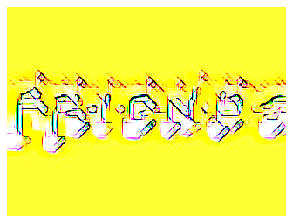

In [94]:
TensorImage(res[0]).show()

Getting worse?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


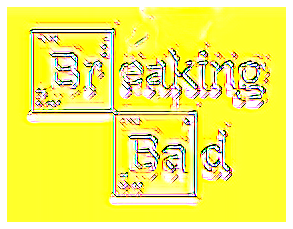

In [109]:
dset = Datasets('/home/ubuntu/datasets/tv_show_logos/breaking_bad.png', tfms=[PILImage.create])
dl = dset.dataloaders(after_item=[ToTensor()], after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)], bs=1)
t_im = dl.one_batch()[0]
with torch.no_grad():
    res = learn.model(t_im)
TensorImage(res[0]).show()